In [1]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using DiffEqSensitivity
using GalacticOptim
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/regularization.jl")
include("src/rom/pod.jl")
include("src/utils/processing_tools.jl")

Main.ProcessingTools

# FOM + ROM solutions

Compute some fom and rom solution u(t, x)

## Test various burgers resolution method for FOM

Experiments with different initial conditions: Gaussian random, high dimensional random, sin, exp, -x, etc.

In [14]:
t_max = 1.;
t_min = 0.;
x_max = pi;
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.04;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

### Godunov

In [4]:
u0 = InitialFunctions.high_dim_random_init(t, x, 10);
#u0 = exp.(-16 .* (x.^2));
# u0 = InitialFunctions.advecting_shock(t, x, nu);
# u0 = InitialFunctions.random_init(t, x);
# u0 = -1 .* collect(x);

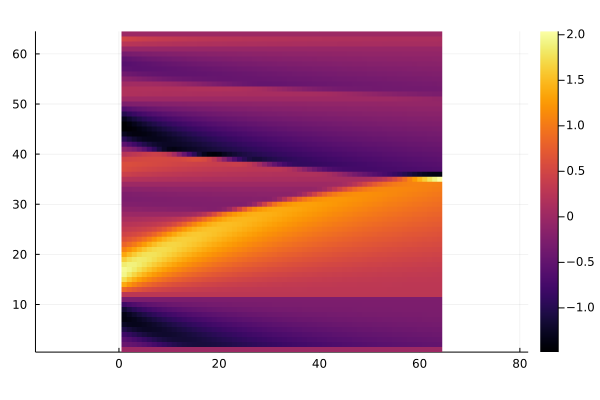

In [5]:
t1, u1 = Equations.get_burgers_godunov(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u1, "") # need to reverse u, odesolver switch dimensions

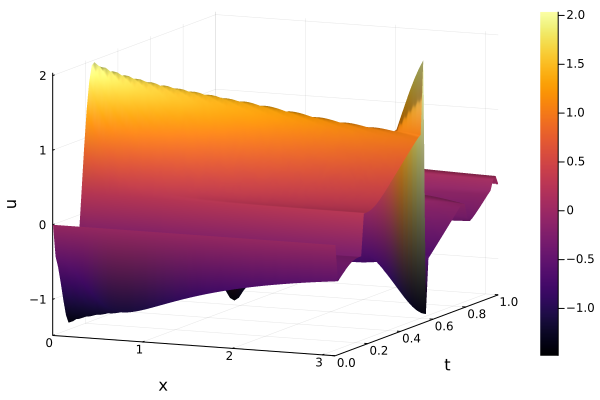

In [6]:
plot(x, t1, u1, st = :surface, xlabel = "x", ylabel = "t", zlabel = "u")
plot!(dpi=300)

### CCDF

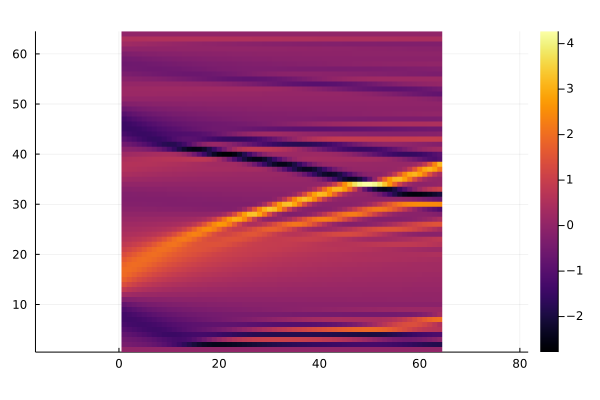

In [7]:
t2, u2 = Equations.get_burgers_ccdf(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u2, "")

### Pseudo-spectral method

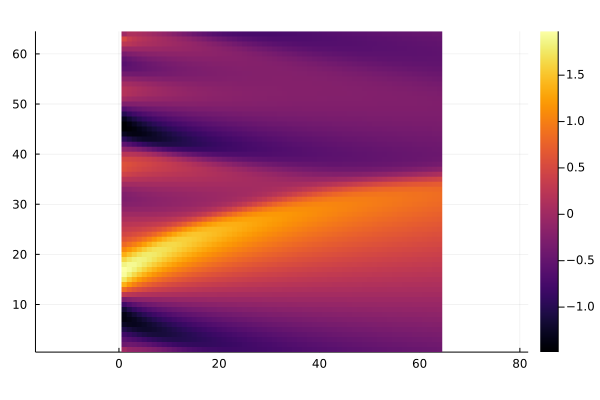

In [8]:
t3, u3 = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u3, "")

### Thesis screenshots

In [9]:
u0 = InitialFunctions.high_dim_random_init(t, x, 10);
high_t, high_dim = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n * 32, x_n * 32, nu, 2);

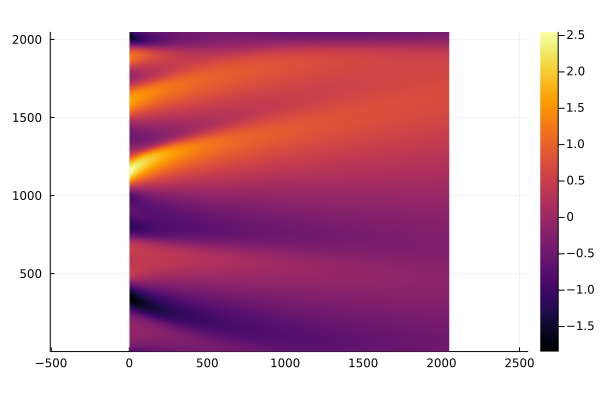

In [10]:
low_dim = ProcessingTools.downsampling(high_dim, 32);
low_t = LinRange(t_min, t_max, t_n);
GraphicTools.show_state(high_dim, "")

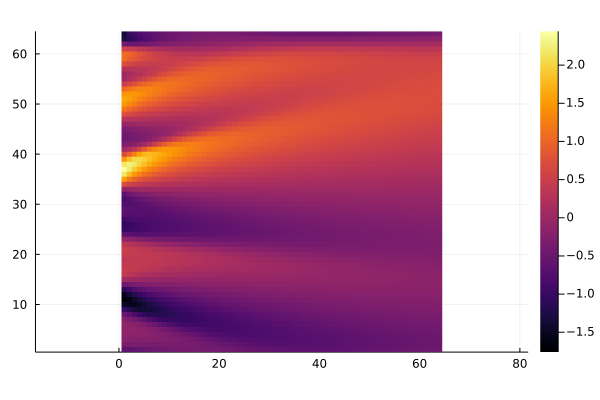

In [11]:
GraphicTools.show_state(low_dim, "")

┌ Warning: dt(2.220446049250313e-16) <= dtmin(2.220446049250313e-16) at t=0.07503928437858336. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/vdesgrange/.julia/packages/SciMLBase/Mn52A/src/integrator_interface.jl:505


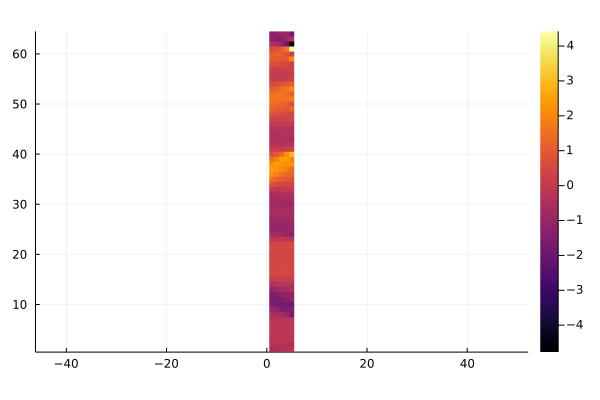

In [12]:
t4, u4 = Equations.get_burgers_fft(t, dx, x_n, 0.0001, low_dim[:, 1]);
GraphicTools.show_state(u4, "")

### POD-GC

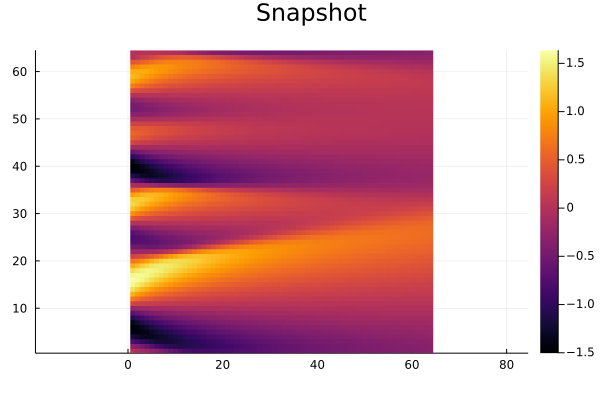

In [13]:
t, u2 = Equations.get_burgers_fft(t, dx, x_n, 0.03, u0[1, :]);
GraphicTools.show_state(u2, "Snapshot") # need to reverse u, odesolver switch dimensions

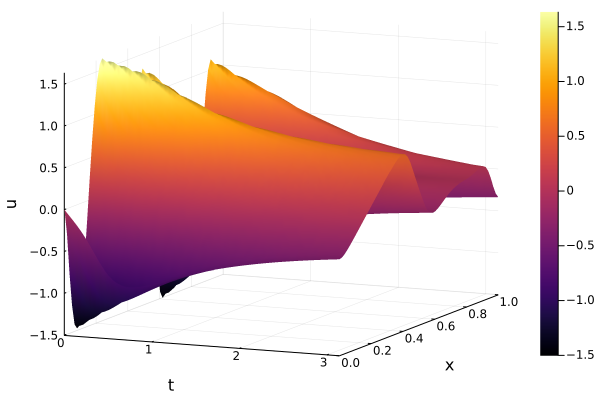

In [14]:
plot(x, t, u2, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

In [15]:
# ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1);
# GraphicTools.show_state(u_a, "Snapshot generator")

In [16]:
bas, ū = POD.generate_pod_basis(u3, true);
ϕ = bas.modes;
coeff = bas.coefficients;
tmp = ϕ[:, 1:3] * coeff[1:3, :] .+ ū;
# display(
#     plot(
#         GraphicTools.show_state(u, ""),
#         GraphicTools.show_state(u2, ""),
#         GraphicTools.show_state(tmp, ""),
#         GraphicTools.show_err(u2, tmp, "");
#         layout = (2, 2)
#     )
# );

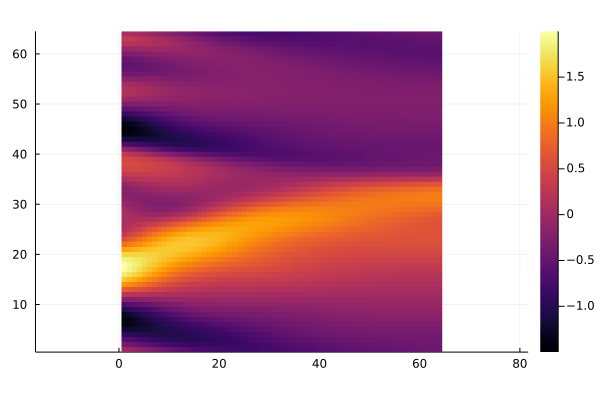

In [17]:
GraphicTools.show_state(tmp, "")
# GraphicTools.show_err(u2, tmp, "")

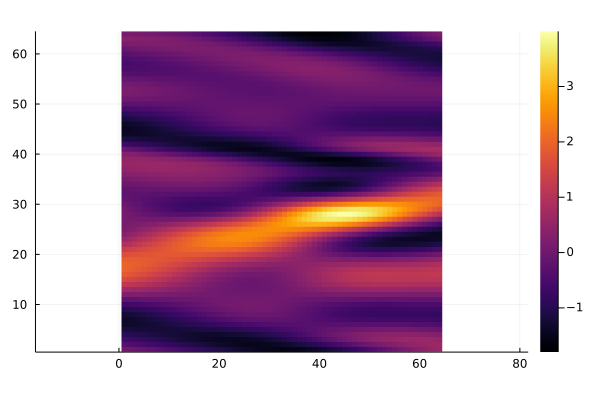

In [18]:
Ū = Equations.galerkin_projection(t, u3, ϕ[:, 1:3], 0., dx, dt);
# display(
#     plot(
#         GraphicTools.show_state(u2, ""),
#         GraphicTools.show_state(Ū, ""),
#         GraphicTools.show_err(u2, Ū, ""),
#         GraphicTools.show_err(u2, Ū, "");
#         layout = (2, 2)
#     )
# );
GraphicTools.show_state(Ū, "")
# GraphicTools.show_err(u2, Ū, "")

## Analytical solution initial conditions

In [2]:
#u0 = InitialFunctions.advecting_shock(t, x, nu);
u0 = exp.(-16 .* (x.^2));
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0);
GraphicTools.show_state(u, "Snapshot")

LoadError: UndefVarError: x not defined

In [3]:
plot(t, x, u, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

LoadError: UndefVarError: t not defined

---
# Generate data

In [5]:
# dataset_1k = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1024, 2, 1, false, "./src/dataset/burgers_high_dim_training_set_2.jld2", "training_set");
# high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
# coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];
# nu_dataset = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_nu_variational_dataset.jld2")["training_set"];
dataset = Generator.read_dataset("./src/examples/burgers/dataset/high_dim_256_set_j173.jld2")["training_set"];

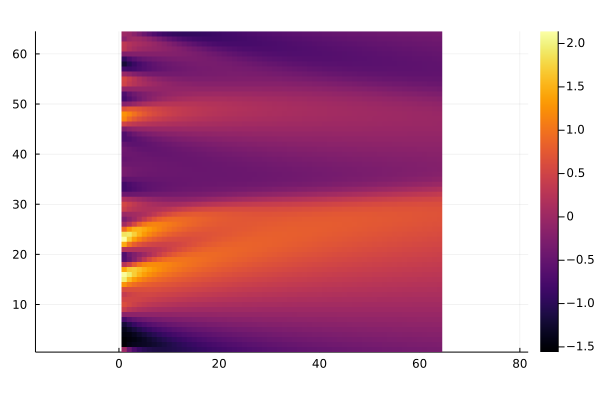

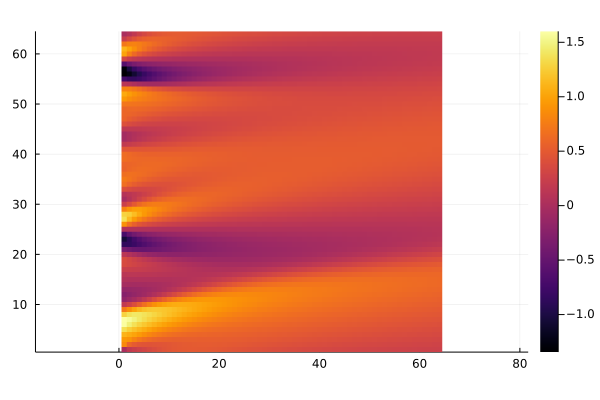

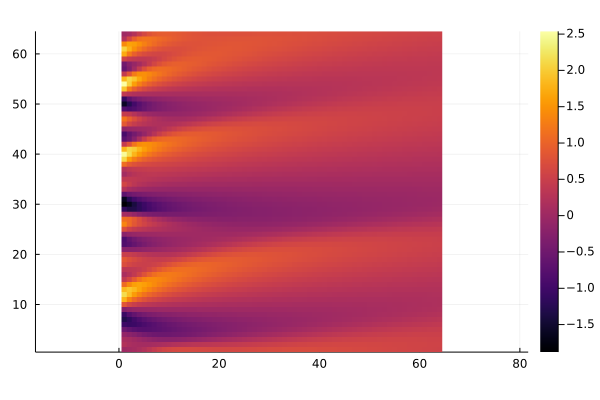

In [6]:
function check_training_dataset(dataset)
    for i in range(1, 3, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(dataset)

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

--- 
# Training with flux

In [41]:
add_dim(x::Array{Float64, 1}) = reshape(x, (size(x)[1], 1, 1, 1))
add_dim(x::Array) = reshape(x, (size(x)[1], 1, 1, size(x)[2]))
del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[4], size(x)[5]))

del_dim (generic function with 1 method)

In [43]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(add_dim(u0), res)
#     prob = ODEProblem{false}(nn, Nothing, (Nothing, Nothing));
#     u_pred = Array(solve(prob, Tsit5(), u0=add_dim(u0), p=p, abstol=1e-9, reltol=1e-9, saveat=t, sensealg=DiffEqSensitivity.BacksolveAdjoint()));
    
    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

check_result (generic function with 1 method)

In [101]:
function training(model, epochs, dataset, batch_size, ratio, lr, noise=0., reg=0., cuda=false)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(true) # false
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end

  model = model |> device
  opt = Flux.Optimiser(Flux.WeightDecay(reg), Flux.RMSProp(lr))
  ltrain = 0.;
  lval = 0.;
  losses = [];

  @info("Loading dataset")
  (train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, batch_size, ratio, false, false);

  @info("Building model")
  p, re = Flux.destructure(model);
  net(u, p, t) = re(p)(u);

  prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));

  function predict_neural_ode(x, t)
    tspan = (t[1], t[end]);
    _prob = remake(prob; u0=x, p=p, tspan=tspan);
    Array(solve(_prob, Tsit5(), u0=x, p=p, abstol=1e-9, reltol=1e-9, saveat=t, sensealg=DiffEqSensitivity.BacksolveAdjoint()));
  end

  function loss(x, y, t)
    u_pred = predict_neural_ode(add_dim(x), t[1]);
    ŷ = Reg.gaussian_augment(del_dim(u_pred), noise);
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))) # + Reg.l2(p, reg);
    return l;
  end

  function traincb()
    ltrain = 0;
    for (x, y, t) in train_loader
      ltrain += loss(x, y, t);
    end
    ltrain /= (train_loader.nobs / train_loader.batchsize);
    @show(ltrain);
  end

  function val_loss(x, y, t)
    u_pred = predict_neural_ode(add_dim(x), t[1]);
    ŷ = del_dim(u_pred);
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
    return l;
  end

  function evalcb()
    lval = 0;
    for (x, y, t) in val_loader
      # (x, y, t) = (x, y, t) |> device;
      lval += val_loss(x, y, t);
    end
    lval /= (val_loader.nobs / val_loader.batchsize);
    @show(lval);
  end

  @info("Train")
  trigger = Flux.plateau(() -> ltrain, 20; init_score = 1, min_dist = 1f-5);
  Flux.@epochs epochs begin
    Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
    trigger() && break;
  end

  return re(p), p, ltrain, lval
end

training (generic function with 4 methods)

In [ ]:
function main()
  batch_size = 32;
  epochs = 100;

  data = Generator.read_dataset("./src/examples/burgers/dataset/high_dim_256_set_j173.jld2")["training_set"];
  model = Models.CNN(64, 3, 5);
  K, p = training(model, epochs, data, batch_size, 0.75, 0.003, 0.05, 1.0e-7, false);
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main In[101]:8
┌ Info: Loading dataset
└ @ Main In[101]:17
┌ Info: Building model
└ @ Main In[101]:20
┌ Info: Train
└ @ Main In[101]:65
┌ Info: Epoch 1
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.7431470190309922
lval = 0.7406957387333781
ltrain = 0.7225505029783942
lval = 0.7227316464777194
ltrain = 0.7079650729316969
lval = 0.7103018329878061
ltrain = 0.6965843942118154
lval = 0.7008852722035259
ltrain = 0.6868524412351129
lval = 0.6940200359992199
ltrain = 0.6772518899623114
lval = 0.6869305543529065


┌ Info: Epoch 2
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.6692433449329377
lval = 0.6813655116524933
ltrain = 0.662294980092566
lval = 0.6746570749591666
ltrain = 0.6548663238030132
lval = 0.6673548996591847
ltrain = 0.6475833591073329
lval = 0.6606139891409565
ltrain = 0.6406035279241268
lval = 0.6553992997725907
ltrain = 0.6344560892859662
lval = 0.6504046091296305


┌ Info: Epoch 3
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.6279533088981774
lval = 0.6441496745645553
ltrain = 0.6211840266161747
lval = 0.6388196183008239
ltrain = 0.6141109660730865
lval = 0.6328613223099998
ltrain = 0.6073515256959288
lval = 0.6271770771136645
ltrain = 0.601013035323855
lval = 0.6215328246250353
ltrain = 0.5943851645456159
lval = 0.6157268420246853


┌ Info: Epoch 4
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.587712035495926
lval = 0.6101719494338583
ltrain = 0.5806613213559436
lval = 0.603631110906923
ltrain = 0.5737702634394487
lval = 0.5971959921189538
ltrain = 0.5665818958445538
lval = 0.5915445849351404
ltrain = 0.5596450574122876
lval = 0.5855310985449762
ltrain = 0.5520442381589423
lval = 0.5784255384841186


┌ Info: Epoch 5
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.5456196158048034
lval = 0.5729326745143442
ltrain = 0.5380666852462176
lval = 0.565990783554754
ltrain = 0.5312230753422893
lval = 0.5602423416237006
ltrain = 0.5234566661715084
lval = 0.5534033829466493
ltrain = 0.5171618476949525
lval = 0.546933056470193
ltrain = 0.5099325908696053
lval = 0.5404386761366606


┌ Info: Epoch 6
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.5033626620697954
lval = 0.5353715837919447
ltrain = 0.4967392437775369
lval = 0.5293503833196519
ltrain = 0.48986492657579245
lval = 0.5226310466254618
ltrain = 0.482220296077986
lval = 0.515609388850017
ltrain = 0.4761301230123279
lval = 0.5089502635127219
ltrain = 0.46916231438624845
lval = 0.5027663376606899


┌ Info: Epoch 7
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.46264317925548326
lval = 0.49689766383197503
ltrain = 0.45596444858619184
lval = 0.48980407011063476
ltrain = 0.45024337493920585
lval = 0.4843609204511102
ltrain = 0.44386238321420285
lval = 0.47842299695581003
ltrain = 0.43782783215432836
lval = 0.47281385391125397
ltrain = 0.43122485783349834
lval = 0.46651860645878185


┌ Info: Epoch 8
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4257496508823402
lval = 0.46190203238141914
ltrain = 0.42009265172338117
lval = 0.4551122188705877
ltrain = 0.41374518243479685
lval = 0.44929561223043013
ltrain = 0.4075895870827664
lval = 0.4430575710113625
ltrain = 0.40139801734021746
lval = 0.4371115792805279
ltrain = 0.39600138066565743
lval = 0.43214473415496657


┌ Info: Epoch 9
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.39090916521400687
lval = 0.42664604553340174
ltrain = 0.38557039111976205
lval = 0.4219640014209834
ltrain = 0.3804702916333597
lval = 0.4165411225993708
ltrain = 0.3747459506158859
lval = 0.4113122657507924
ltrain = 0.3695126303026383
lval = 0.4064133203595318
ltrain = 0.36380379617702546
lval = 0.40045084759362315


┌ Info: Epoch 10
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3591782182491599
lval = 0.3963250104099043
ltrain = 0.354236558348074
lval = 0.39099918612296264
ltrain = 0.3491439709705118
lval = 0.38539824684055357
ltrain = 0.34430497619119876
lval = 0.3807677099496575
ltrain = 0.34016994965686465
lval = 0.37624009370295364
ltrain = 0.33503283820539104
lval = 0.37167144502617544


┌ Info: Epoch 11
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3304688681288253
lval = 0.36678292493083664
ltrain = 0.32638683871929536
lval = 0.36212141734215697
ltrain = 0.32239453803051277
lval = 0.3581398618181185
ltrain = 0.3174827289682621
lval = 0.35359241031432853
ltrain = 0.31332380611174254
lval = 0.34948903332329845
ltrain = 0.30896559806032725
lval = 0.3453880404950195


┌ Info: Epoch 12
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3050367283273983
lval = 0.34111244506070126
ltrain = 0.3012642429120909
lval = 0.33794204270719985
ltrain = 0.29725575704196255
lval = 0.33352188719253895
ltrain = 0.293620200218347
lval = 0.32953059258574907
ltrain = 0.28976758634501837
lval = 0.3252936587011385
ltrain = 0.28558444766340163
lval = 0.32145194083509093


┌ Info: Epoch 13
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.28230289661665053
lval = 0.31864430279098477
ltrain = 0.27844109598884664
lval = 0.3147491678484033
ltrain = 0.2749678294364122
lval = 0.31159748609688087
ltrain = 0.2713254864079095
lval = 0.3070965410617537
ltrain = 0.26814103104506376
lval = 0.3039050171915396
ltrain = 0.2645150333931698
lval = 0.29990121943035775


┌ Info: Epoch 14
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.26159084488780854
lval = 0.2968145182049282
ltrain = 0.2582880452629967
lval = 0.2934430087914994
ltrain = 0.2550754072191905
lval = 0.2903120278826815
ltrain = 0.25177255192684367
lval = 0.2874146368613816
ltrain = 0.24864834753618867
lval = 0.28347876089950885
ltrain = 0.24575334683648062
lval = 0.28043200477668034


┌ Info: Epoch 15
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.24308080254867048
lval = 0.2771822007700136
ltrain = 0.2401697795552645
lval = 0.27420855573399305
ltrain = 0.2373153435537798
lval = 0.2713657959454188
ltrain = 0.23436914225402816
lval = 0.2689359997581479
ltrain = 0.23147601488310474
lval = 0.2657994414755016
ltrain = 0.2287255629971433
lval = 0.26296278903968484


┌ Info: Epoch 16
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.22650870552995186
lval = 0.26003851434195324
ltrain = 0.22385258256506815
lval = 0.2575204035244282
ltrain = 0.22119988221371803
lval = 0.25525006191544425
ltrain = 0.21867848432279838
lval = 0.2532069273444219
ltrain = 0.21610371515094481
lval = 0.25056591219558766
ltrain = 0.21336347099936995
lval = 0.2471679256150819


┌ Info: Epoch 17
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2111516328847576
lval = 0.24478782659108958
ltrain = 0.20894180270877394
lval = 0.24273895180785082
ltrain = 0.2066440763602497
lval = 0.24037344238258043
ltrain = 0.20402894269356367
lval = 0.23777348839238852
ltrain = 0.2018520009693644
lval = 0.23549932202091814
ltrain = 0.19960418300406613
lval = 0.2325422286789662


┌ Info: Epoch 18
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1978145174236596
lval = 0.23074885634034326
ltrain = 0.19569440100857016
lval = 0.22840977504850515
ltrain = 0.19349931308618437
lval = 0.2262414860798856
ltrain = 0.19151334972639678
lval = 0.22411948607945106
ltrain = 0.18932915256115387
lval = 0.22203898495667804
ltrain = 0.18714567049163122
lval = 0.21980462241371101


┌ Info: Epoch 19
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18547052372586972
lval = 0.21788470126452786
ltrain = 0.18360950027863662
lval = 0.2162983464707899
ltrain = 0.1818256100007614
lval = 0.21383777351440098
ltrain = 0.17995913365254176
lval = 0.2116141019225351
ltrain = 0.1779616608007032
lval = 0.20996427695389858
ltrain = 0.17587574322102328
lval = 0.20759465799219923


┌ Info: Epoch 20
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.17428600335195113
lval = 0.206060585136577
ltrain = 0.1726969667697802
lval = 0.20446976328599248
ltrain = 0.17086022069459225
lval = 0.20210334031894062
ltrain = 0.1690045526698488
lval = 0.20045988436093104
ltrain = 0.1673314736211594
lval = 0.19885142578845538
ltrain = 0.1656890456901509
lval = 0.19695324395599081


┌ Info: Epoch 21
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16435972013538067
lval = 0.19577925538391766
ltrain = 0.16299715827354425
lval = 0.19412029657621388
ltrain = 0.16135670575284766
lval = 0.19203165135064093
ltrain = 0.15976573962105434
lval = 0.19081026618624267
ltrain = 0.15804456482196236
lval = 0.18869976892295026
ltrain = 0.1563792332258635
lval = 0.18705707881622796


┌ Info: Epoch 22
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15501600642344235
lval = 0.1856607265398172
ltrain = 0.15380649761688667
lval = 0.18391257219021806
ltrain = 0.15238400524006226
lval = 0.1823780793531873
ltrain = 0.15078378599537504
lval = 0.1811246155556669
ltrain = 0.1492699941164606
lval = 0.17955466897875744
ltrain = 0.14799640444984874
lval = 0.17774862752605367


┌ Info: Epoch 23
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14672166595847894
lval = 0.1762668030860317
ltrain = 0.14539727242411357
lval = 0.1750085189240728
ltrain = 0.14434464955465626
lval = 0.17373798243318628
ltrain = 0.1429043177598076
lval = 0.17207123850709574
ltrain = 0.1415366962147301
lval = 0.17108435591340812
ltrain = 0.14022639665201397
lval = 0.16961247585674927


┌ Info: Epoch 24
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13932145940686116
lval = 0.168419856816613
ltrain = 0.13800400606976146
lval = 0.16711532259425124
ltrain = 0.13681888869892192
lval = 0.1656305135745844
ltrain = 0.13564524564380676
lval = 0.1646042393266791
ltrain = 0.13452937119463623
lval = 0.1634972628786063
ltrain = 0.1333095217460013
lval = 0.1619128779040696


┌ Info: Epoch 25
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13228380694208233
lval = 0.16062015611722802
ltrain = 0.13124647017805252
lval = 0.15936892917215428
ltrain = 0.13004642868559432
lval = 0.1581216837499486
ltrain = 0.12891037349007498
lval = 0.15699447028586536
ltrain = 0.1279981597097542
lval = 0.15594761759866527
ltrain = 0.1270087440466593
lval = 0.15488875272180602


┌ Info: Epoch 26
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12614543132148603
lval = 0.1536555062401812
ltrain = 0.1251314235120034
lval = 0.1525686298241266
ltrain = 0.12417113664078934
lval = 0.15141213383912605
ltrain = 0.1231631948595381
lval = 0.15050063918777712
ltrain = 0.12211757746465074
lval = 0.14932046394621257
ltrain = 0.12107769985468597
lval = 0.14825334802717677


┌ Info: Epoch 27
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12028693113209633
lval = 0.14725606923894574
ltrain = 0.11941869681258649
lval = 0.14670893312522085
ltrain = 0.11858172202393923
lval = 0.1457836391739513
ltrain = 0.11770684161171935
lval = 0.1448246203944736
ltrain = 0.11674162310760879
lval = 0.14326172523666203
ltrain = 0.11573362956225552
lval = 0.14216278311318079


┌ Info: Epoch 28
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1151015967885675
lval = 0.14113730262836502
ltrain = 0.11438352415322749
lval = 0.13999069399580621
ltrain = 0.11350924241022176
lval = 0.13925493946302941
ltrain = 0.11246779274130615
lval = 0.13841305890685612
ltrain = 0.11182292480981622
lval = 0.13783428094193642
ltrain = 0.1108892887376357
lval = 0.13663715961361134


┌ Info: Epoch 29
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11015925704635325
lval = 0.13602087391975187
ltrain = 0.10953071824218685
lval = 0.1352857736802274
ltrain = 0.10874630886279464
lval = 0.13444696348626123
ltrain = 0.10795963683564724
lval = 0.1331795571933419
ltrain = 0.10726211376378258
lval = 0.13196633052174686
ltrain = 0.10640705354652837
lval = 0.13118821717361107


┌ Info: Epoch 30
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1059480260863294
lval = 0.13089283642084615
ltrain = 0.10527626299214272
lval = 0.13053546627676457
ltrain = 0.10469003435498563
lval = 0.12899209326409838
ltrain = 0.10391056936259785
lval = 0.1281216132385591
ltrain = 0.10311737162706386
lval = 0.12727328874658617
ltrain = 0.10236367827802245
lval = 0.1263725470998607


┌ Info: Epoch 31
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10178946490655122
lval = 0.1256028544297039
ltrain = 0.10125732284054982
lval = 0.12540542608942226
ltrain = 0.10049452386419228
lval = 0.12415221909162802
ltrain = 0.0999530738167812
lval = 0.12342353900847841
ltrain = 0.09927910717182925
lval = 0.12268660561069211
ltrain = 0.09854429507986841
lval = 0.12203518114333367


┌ Info: Epoch 32
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09822023244985582
lval = 0.12141867725624686
ltrain = 0.09758181330366184
lval = 0.12065940949545892
ltrain = 0.09699071844061058
lval = 0.12008512406338626
ltrain = 0.09645263825412748
lval = 0.11987979863494963
ltrain = 0.09578326623240196
lval = 0.11900106996560318
ltrain = 0.09510126816027258
lval = 0.1179495684840011


┌ Info: Epoch 33
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09477176655676683
lval = 0.11811804360788232
ltrain = 0.09437244163149287
lval = 0.11691269401764287
ltrain = 0.09369977695520554
lval = 0.11605238264050148
ltrain = 0.0931572583359354
lval = 0.11508235595919332
ltrain = 0.09260523619169046
lval = 0.11429755061786571
ltrain = 0.09197000400684917
lval = 0.11398280746157768


┌ Info: Epoch 34
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09145544635798243
lval = 0.1136505189572719
ltrain = 0.09099256357398966
lval = 0.11269943237848307
ltrain = 0.09069947427483245
lval = 0.1124409690906677
ltrain = 0.09015387269489934
lval = 0.1114844273539108
ltrain = 0.08951501579616226
lval = 0.11093905493911066
ltrain = 0.08907316730931021
lval = 0.11053188710993789


┌ Info: Epoch 35
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08886836875709593
lval = 0.11003910280860996
ltrain = 0.08826072412185032
lval = 0.10918743250241895
ltrain = 0.08783395956552205
lval = 0.10845776216234235
ltrain = 0.08750255046918198
lval = 0.10833916755735157
ltrain = 0.08692175845324161
lval = 0.10769598957109058
ltrain = 0.0865051901639064
lval = 0.10767060544272336


┌ Info: Epoch 36
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08622601395668526
lval = 0.10677941911347055
ltrain = 0.08568127844539007
lval = 0.10611461458548042
ltrain = 0.08530425221379793
lval = 0.10591081629011041
ltrain = 0.0849719528283619
lval = 0.105680554092355
ltrain = 0.08447092379445764
lval = 0.10545067922465205
ltrain = 0.08392444262396771
lval = 0.10413730287305076


┌ Info: Epoch 37
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08369839843709927
lval = 0.10434202245746825
ltrain = 0.08346705861626295
lval = 0.10376951427741682
ltrain = 0.08289565215433188
lval = 0.10345612941359861
ltrain = 0.08251619075194964
lval = 0.10229072858966407
ltrain = 0.082161418316942
lval = 0.1019239979447445
ltrain = 0.0816924047030831
lval = 0.10117439429165848


┌ Info: Epoch 38
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08148717394849343
lval = 0.10126637905686292
ltrain = 0.08110451286824388
lval = 0.10089284895363923
ltrain = 0.08073094179487984
lval = 0.10037637039896251
ltrain = 0.0803723879556899
lval = 0.09970912948695934
ltrain = 0.07996795115179224
lval = 0.09931236546790363
ltrain = 0.07971439466552217
lval = 0.09905160576380755


┌ Info: Epoch 39
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07956598738642405
lval = 0.0989985228317541
ltrain = 0.07917306774374831
lval = 0.0986096583888561
ltrain = 0.07876560325460195
lval = 0.09751997687864285
ltrain = 0.07849471364887435
lval = 0.09778244944748163
ltrain = 0.07812559394271218
lval = 0.09676420451837861
ltrain = 0.07775799601038322
lval = 0.09670426507018783


┌ Info: Epoch 40
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07757402337894118
lval = 0.09643355168230226
ltrain = 0.07719705476705223
lval = 0.09563261140868654
ltrain = 0.07698641943218014
lval = 0.09557219496334533
ltrain = 0.07654503566695901
lval = 0.09480201958377527
ltrain = 0.07623968910390132
lval = 0.09479165202535507
ltrain = 0.07593855617515553
lval = 0.09470831818912762


┌ Info: Epoch 41
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07573575970100933
lval = 0.0940125529176998
ltrain = 0.07546824948491919
lval = 0.0939420080036359
ltrain = 0.07526224090312904
lval = 0.0937140331635323
ltrain = 0.07502831747876783
lval = 0.09273898716682295
ltrain = 0.07479448452195432
lval = 0.09238947275262169
ltrain = 0.07438568568486435
lval = 0.09268142452590428


┌ Info: Epoch 42
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07407702131904058
lval = 0.09230936019118628
ltrain = 0.07377034530045389
lval = 0.09189120290158317
ltrain = 0.07350239092795886
lval = 0.09233860457803039
ltrain = 0.07330759473839417
lval = 0.09178509074151994
ltrain = 0.0730492010243023
lval = 0.09080994399035895
ltrain = 0.0727636436272852
lval = 0.09045836099585342


┌ Info: Epoch 43
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07262613683572207
lval = 0.08966627352297621
ltrain = 0.07237319126155094
lval = 0.08998972062265723
ltrain = 0.07216513022705388
lval = 0.0900909832390086
ltrain = 0.07203500618182901
lval = 0.09036710194987954
ltrain = 0.07152351187364825
lval = 0.08916701649982488
ltrain = 0.07126055149965883
lval = 0.08878260140415764


┌ Info: Epoch 44
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07115775278210616
lval = 0.08824878770932545
ltrain = 0.0710444016499786
lval = 0.0884097852427094
ltrain = 0.07077538182317167
lval = 0.08761979997587906
ltrain = 0.07040667212975275
lval = 0.08758332114492973
ltrain = 0.07030634807093612
lval = 0.08737307413393428
ltrain = 0.06999393947599554
lval = 0.08749967357447963


┌ Info: Epoch 45
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07001887078280396
lval = 0.08764237167215276
ltrain = 0.0697657160730163
lval = 0.08696852520319805
ltrain = 0.06938242158797368
lval = 0.08673548241841901
ltrain = 0.06933268483009668
lval = 0.08697894060776151
ltrain = 0.06891780277775968
lval = 0.08598698800242863
ltrain = 0.0688090023977218
lval = 0.08504312473578138


┌ Info: Epoch 46
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06858628957843887
lval = 0.08532103585210594
ltrain = 0.0684806031566786
lval = 0.08490254716852028
ltrain = 0.06825815789788785
lval = 0.08485395239574148
ltrain = 0.06786309759829692
lval = 0.08479518224744911
ltrain = 0.06766931114736334
lval = 0.08438244482671195
ltrain = 0.06750327580383829
lval = 0.08434007416371062


┌ Info: Epoch 47
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0674512347842065
lval = 0.08393639862177094
ltrain = 0.06732993460475067
lval = 0.08379093043197891
ltrain = 0.06712764305247508
lval = 0.08417228578791618
ltrain = 0.06690192512559799
lval = 0.08367325559236943
ltrain = 0.06658861437630714
lval = 0.08339496397485566
ltrain = 0.06636674718941751
lval = 0.08299644694039107


┌ Info: Epoch 48
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06651142049224086
lval = 0.08353576792416895
ltrain = 0.06630591830272269
lval = 0.08262954594363131
ltrain = 0.06612906581510063
lval = 0.08225889933148758
ltrain = 0.06587606335538447
lval = 0.08232094363988221
ltrain = 0.06558343195692287
lval = 0.0815289122347279
ltrain = 0.06533512362076378
lval = 0.08180075945110678


┌ Info: Epoch 49
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06531426878536253
lval = 0.08183577819741228
ltrain = 0.06527697465773954
lval = 0.08178076664468045
ltrain = 0.06506071214377025
lval = 0.08128914912881863
ltrain = 0.06475541903971069
lval = 0.08060585052553756
ltrain = 0.06460969125585908
lval = 0.08066811283979133
ltrain = 0.0642572957575072
lval = 0.08070381682980632


┌ Info: Epoch 50
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06447507019167163
lval = 0.0810314064679945
ltrain = 0.06428699347098843
lval = 0.08125931817204349
ltrain = 0.06401756318118436
lval = 0.08060844010112356
ltrain = 0.0638659723636516
lval = 0.08068360048199574
ltrain = 0.06386120430934263
lval = 0.08039946259389387
ltrain = 0.06354655136699165
lval = 0.07941379831118917


┌ Info: Epoch 51
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06349593332484299
lval = 0.07950007054599159
ltrain = 0.06319643288182408
lval = 0.07944584074238996
ltrain = 0.06304618906111496
lval = 0.07923873730111208
ltrain = 0.0630430505990472
lval = 0.07934055980407437
ltrain = 0.06288129604653568
lval = 0.07915555776556868
ltrain = 0.06258686354672223
lval = 0.07824136382631322


┌ Info: Epoch 52
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06261214625799602
lval = 0.0784132811476761
ltrain = 0.06263843011129343
lval = 0.07871974015568783
ltrain = 0.06249107824199105
lval = 0.07869299559338278
ltrain = 0.06221377493322574
lval = 0.07831033721620917
ltrain = 0.061890833270097874
lval = 0.07764007401809297
ltrain = 0.06192197586550341
lval = 0.07781271698024604


┌ Info: Epoch 53
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06182860900905488
lval = 0.07771045585693126
ltrain = 0.06173299115857219
lval = 0.07781511502971379
ltrain = 0.06166673228051586
lval = 0.07749214202154064
ltrain = 0.06157097284996705
lval = 0.07710676897455712
ltrain = 0.06119135939873712
lval = 0.07708778979455257
ltrain = 0.06116796804029778
lval = 0.07729203368904312


┌ Info: Epoch 54
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06114610899594419
lval = 0.07761402736339999
ltrain = 0.06119589350060566
lval = 0.0778003742606363
ltrain = 0.06093949517587196
lval = 0.07723437974242858
ltrain = 0.06064357454971744
lval = 0.07666676792520902
ltrain = 0.060501670593813166
lval = 0.07590883224380679
ltrain = 0.060460357407917116
lval = 0.0758653099323717


┌ Info: Epoch 55
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.060467919695037314
lval = 0.07608114585052542
ltrain = 0.06022646430874148
lval = 0.07578871476150613
ltrain = 0.06022553625181538
lval = 0.07611859230787747
ltrain = 0.06003982713696703
lval = 0.07622763956806874
ltrain = 0.05994462624796835
lval = 0.0756970068578755
ltrain = 0.05959012791469212
lval = 0.0751527798206351


┌ Info: Epoch 56
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.059545327532789384
lval = 0.0750809201659606
ltrain = 0.05971476400296415
lval = 0.07541989228046421
ltrain = 0.05960683633562747
lval = 0.07463373443284883
ltrain = 0.05975413851810771
lval = 0.07627333961963435
ltrain = 0.0593359026401371
lval = 0.07540603750755223
ltrain = 0.059039051872754135
lval = 0.07516937206923022


┌ Info: Epoch 57
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05903575395273975
lval = 0.07515123490589819
ltrain = 0.05893848518624096
lval = 0.07466059252046169
ltrain = 0.05882029124256158
lval = 0.07526280412139047
ltrain = 0.05880042215120727
lval = 0.07509263566847879
ltrain = 0.058614268240641726
lval = 0.07535569537710558
ltrain = 0.05829228208252999
lval = 0.07422306670165137


┌ Info: Epoch 58
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05862030231866727
lval = 0.07464972917667077
ltrain = 0.058444026092233765
lval = 0.07426147947580206
ltrain = 0.058453709830041965
lval = 0.07397269744248897
ltrain = 0.05819753586579335
lval = 0.0742395423320135
ltrain = 0.057894545837449025
lval = 0.07354773199802647
ltrain = 0.057809940146892835
lval = 0.07292475094141102


┌ Info: Epoch 59
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05795202172114632
lval = 0.07337024123202543
ltrain = 0.05771656733431805
lval = 0.07337486352545267
ltrain = 0.05780108808528034
lval = 0.07407251046730219
ltrain = 0.05755957813184445
lval = 0.07296756393364937
ltrain = 0.05745972681736209
lval = 0.07276988694781368
ltrain = 0.05746400110794928
lval = 0.0727648647269867


┌ Info: Epoch 60
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05727621288870008
lval = 0.07324762697357683
ltrain = 0.057203514191713066
lval = 0.07267675228393417
ltrain = 0.05707477178725551
lval = 0.0723651599133587
ltrain = 0.05708015421144854
lval = 0.07264838003256147
ltrain = 0.0568771037241931
lval = 0.07260329000185789
ltrain = 0.056821801228279116
lval = 0.07241601861000158


┌ Info: Epoch 61
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05672840875957296
lval = 0.0719843136604724
ltrain = 0.05701182596638898
lval = 0.07202657636545476
ltrain = 0.056767025283075735
lval = 0.07204767811301044
ltrain = 0.0566941239220655
lval = 0.07176505779681085
ltrain = 0.05676818216246607
lval = 0.07201998649826695
ltrain = 0.05636192632600746
lval = 0.07298921892894922


┌ Info: Epoch 62
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05637562594979831
lval = 0.07299041378441636
ltrain = 0.05623104182808957
lval = 0.07315236479182247
ltrain = 0.05629717563491298
lval = 0.07225543281861327
ltrain = 0.05618154458705679
lval = 0.07208678649230679
ltrain = 0.05601822087712207
lval = 0.0721963334644729
ltrain = 0.05597391814636372
lval = 0.0723432089415033


┌ Info: Epoch 63
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05581295259857868
lval = 0.07211225555286463
ltrain = 0.05575982470995287
lval = 0.07145390044929248
ltrain = 0.05544924840777027
lval = 0.07110906706744784
ltrain = 0.0555870639109918
lval = 0.0719078973760493
ltrain = 0.0552703051198035
lval = 0.07181137876715146
ltrain = 0.05505808645074898
lval = 0.0711234868668


┌ Info: Epoch 64
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.055402759954736674
lval = 0.07141130549763938
ltrain = 0.055463106418148445
lval = 0.07214559437546082
ltrain = 0.05512323705505453
lval = 0.07156598427264683
ltrain = 0.055080130687884206
lval = 0.07075935650401696
ltrain = 0.054834681506023136
lval = 0.07115246906682071
ltrain = 0.055220126262920825
lval = 0.07097716909369683


┌ Info: Epoch 65
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0551013205833027
lval = 0.07099713415997194
ltrain = 0.05506992170176268
lval = 0.07036585094525077
ltrain = 0.054831223384422756
lval = 0.07100428329535083
ltrain = 0.054724014013545076
lval = 0.07060111052976414
ltrain = 0.05465898990351758
lval = 0.07053951167148151
ltrain = 0.05467190146669734
lval = 0.07040687730051683


┌ Info: Epoch 66
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05436340418272009
lval = 0.06969360358638921
ltrain = 0.054480187078522396
lval = 0.07008757027030235
ltrain = 0.05447583520889413
lval = 0.07147956930219734
ltrain = 0.054371346390317134
lval = 0.07082300999427452
ltrain = 0.054161237141771214
lval = 0.06992223342299796
ltrain = 0.0541202818432631
lval = 0.0708175769567338


┌ Info: Epoch 67
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05413056273912873
lval = 0.06979754527418035
ltrain = 0.054034770530875985
lval = 0.06927178182396498
ltrain = 0.05395427213939763
lval = 0.0689433212183748
ltrain = 0.0538732050160159
lval = 0.0690939871279882


In [12]:
# @save "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K
# @load "./src/examples/burgers/models/tuning_burgers_basicautoencoder_20.bson" K p

In [96]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);

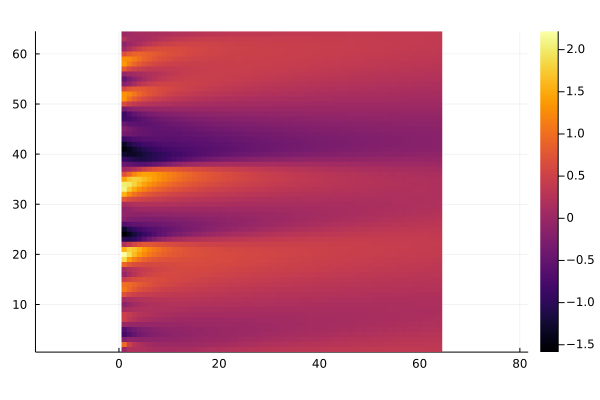

In [99]:
# check_result(K, p, 2)
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t)
u_pred = prob_neuralode(add_dim(u0), p)
GraphicTools.show_state(u, "")

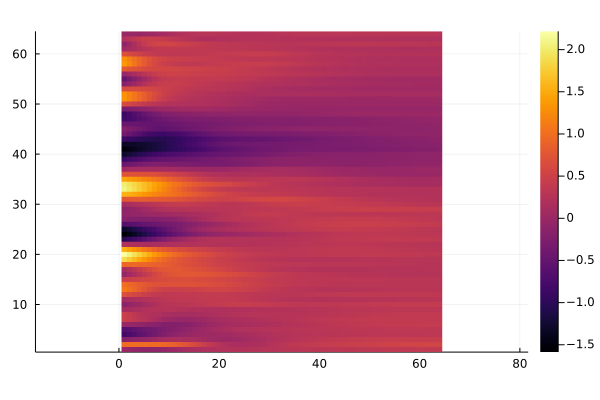

In [100]:
GraphicTools.show_state(hcat(u_pred.u...)[:, :, 1, 1], "")

In [ ]:
data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, false);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Rosenbrock23(), saveat=t);
i = 43
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)